# Color cut code

In this notebook, I run down how I'm doing color cuts to try and get M dwarfs with debris disks, step by step. I'll have plots along the way to demonstrate what each cut looks like, and what the remainder looks like after each cut.

We start, as always, with importing our package dependencies.

In [1]:
import operator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
import matplotlib as mpl
from pprint import pprint
import re
import time
import json
import pandas as pd
import math
from scipy.stats import kde
import scipy.stats as stats
import scipy.sparse
import scipy.ndimage
import scipy.special as sp
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d


print 'Packages read in.'
mpl.__version__

Packages read in.


'2.1.0'

Next, we initialize the FullSubject class, and design the FullSubject object. This is where we will put all our subjects, store their photometry and colors as attributes.

In [2]:
class FullSubject:
    def __init__(self, vec):
        self.zooniverse_id = vec[1]
        self.wiseid = vec[0]
        self.ra = float(vec[12])
        self.dec = float(vec[13])
        self.glong = float(vec[14])
        self.glat = float(vec[15])
        self.state = vec[11]
        if (float(vec[4]) > 0.):
            if float(vec[5])/float(vec[4]) > 0.5:
                self.majgood = True
            else:
                self.majgood = False
        else:
            self.majgood = False

        if type(vec[2]) is str:
            self.vetted = True
        else:
            self.vetted = False
        self.jmag = float(vec[26])
        self.jmagerr = float(vec[27])
        self.hmag = float(vec[28])
        self.hmagerr = float(vec[29])
        self.kmag = float(vec[30])
        self.kmagerr = float(vec[31])
        self.w1mag = float(vec[16])
        self.w1magerr = float(vec[17])
        self.w2mag = float(vec[18])
        self.w2magerr = float(vec[19])
        self.w3mag = float(vec[20])
        self.w3magerr = float(vec[21])
        self.w4mag = float(vec[22])
        self.w4magerr = float(vec[23])

        self.gmag = float(vec[60])
        self.gmagerr = float(vec[61])
        self.imag = float(vec[62])
        self.imagerr = float(vec[63])
        self.rmag = float(vec[64])
        self.rmagerr = float(vec[65])
        self.ymag = float(vec[66])
        self.ymagerr = float(vec[67])
        self.zmag = float(vec[68])
        self.zmagerr = float(vec[69])
        

        self.jminh = self.jmag - self.hmag 
        self.hmink = self.hmag - self.kmag
        self.jmink = self.jmag - self.kmag
        self.w1minw2 = self.w1mag - self.w2mag
        self.w2minw3 = self.w2mag - self.w3mag
        
        self.hmink_err = np.sqrt((self.hmagerr**2)+(self.kmagerr**2))

        self.gminr = self.gmag - self.rmag
        self.rmini = self.rmag - self.imag
        self.iminz = self.imag - self.zmag
        self.zminy = self.zmag - self.ymag

        self.w3xs = self.w1mag - self.w3mag
        self.w3xserr = np.sqrt((self.w1magerr**2) + (self.w3magerr**2))
        self.w4xs = self.w1mag - self.w4mag
        self.w4xserr = np.sqrt((self.w1magerr**2) + (self.w4magerr**2))
        self.sourcevec = vec

        self.e_bminv = float(vec[-1])
        self.a_r = 2.285 * self.e_bminv
        a_w3 = self.a_r * 0.13
        
        if np.abs(self.glat) < 30.:
            a_j = (self.a_r * 0.3223 * (10.**(0.0060*(np.abs(self.glat)-30.)))) 
            a_h = (self.a_r * 0.2302 * (10.**(0.0199*(np.abs(self.glat)-30.)))) 
            a_k = (self.a_r * 0.1666 * (10.**(0.0363*(np.abs(self.glat)-30.)))) 
            a_w1 = (self.a_r * 0.1100 * (10.**(0.0599*(np.abs(self.glat)-30.)))) 
            a_w2 = (self.a_r * 0.0633 * (10.**(0.0453*(np.abs(self.glat)-30.)))) 

            self.jmag_dereddened = self.jmag - a_j
            
            self.hmag_dereddened = self.hmag - a_h

            self.kmag_dereddened = self.kmag - a_k

            self.w1mag_dereddened = self.w1mag - a_w1

            self.w2mag_dereddened = self.w2mag - a_w2
            
            self.w3mag_dereddened = self.w3mag - a_w3

        else:
            self.jmag_dereddened = self.jmag - (self.a_r * 0.3223)
            self.hmag_dereddened = self.hmag - (self.a_r * 0.2302)
            self.kmag_dereddened = self.kmag - (self.a_r * 0.1666)
            self.w1mag_dereddened = self.w1mag - (self.a_r * 0.1100)
            self.w2mag_dereddened = self.w2mag - (self.a_r * 0.0633)
            self.w3mag_dereddened = self.w3mag - a_w3
            

        self.jminh_dereddened = self.jmag_dereddened - self.hmag_dereddened
        self.hmink_dereddened = self.hmag_dereddened - self.kmag_dereddened
        self.jmink_dereddened = self.jmag_dereddened - self.kmag_dereddened
        self.w1minw2_dereddened = self.w1mag_dereddened - self.w2mag_dereddened
        self.w2minw3_dereddened = self.w2mag_dereddened - self.w3mag_dereddened
       
        self.jminh_correction = self.jminh_dereddened - self.jminh
        self.hmink_correction = self.hmink_dereddened - self.hmink
        self.jmink_correction = self.jmink_dereddened - self.jmink
        self.w1minw2_correction = self.w1minw2_dereddened - self.w1minw2
        self.w2minw3_correction = self.w2minw3_dereddened - self.w2minw3

        if self.jminh_dereddened < -0.5:
            self.jmag_dereddened_use = self.jmag
            self.hmag_dereddened_use = self.hmag
            self.kmag_dereddened_use = self.kmag
            self.w1mag_dereddened_use = self.w1mag
            self.w2mag_dereddened_use = self.w2mag
            self.w3mag_dereddened_use = self.w3mag
            self.jminh_dereddened_use = self.jminh
            self.hmink_dereddened_use = self.hmink
            self.jmink_dereddened_use = self.jmink
            self.w1minw2_dereddened_use = self.w1minw2
            self.w2minw3_dereddened_use = self.w2minw3
        else:
            self.jmag_dereddened_use = self.jmag_dereddened
            self.hmag_dereddened_use = self.hmag_dereddened
            self.kmag_dereddened_use = self.kmag_dereddened
            self.w1mag_dereddened_use = self.w1mag_dereddened
            self.w2mag_dereddened_use = self.w2mag_dereddened
            self.w3mag_dereddened_use = self.w3mag_dereddened
            self.jminh_dereddened_use = self.jminh_dereddened
            self.hmink_dereddened_use = self.hmink_dereddened
            self.jmink_dereddened_use = self.jmink_dereddened
            self.w1minw2_dereddened_use = self.w1minw2_dereddened
            self.w2minw3_dereddened_use = self.w2minw3_dereddened
            
    
        self.jminh_correction_use = self.jminh_dereddened_use - self.jminh
        self.hmink_correction_use = self.hmink_dereddened_use - self.hmink
        self.jmink_correction_use = self.jmink_dereddened_use - self.jmink
        self.w1minw2_correction_use = self.w1minw2_dereddened_use - self.w1minw2
        self.w2minw3_correction_use = self.w2minw3_dereddened_use - self.w2minw3

    def __str__(self):
        s = ''
        for entry in self.sourcevec:
            s = s + str(entry) + ','

        s = s[:-1]

        return s

Next, a function for reading files in.

In [3]:
def get_data(filename):
    df = pd.read_csv(filename, low_memory=False)
    data = df.values

    print 'Data table read in'
    
    data_use = data[4:,:]
    length = data_use[:,0].size

    labels = data[3,:]

    object_list = [None for var in range(length)]

    list_index = 0
    
    for linevec in data_use:
        object_list[list_index] = FullSubject(linevec)
        list_index += 1
    
    return object_list, labels

obj_test, label_test = get_data('DD_2017-12-05_Mdwarf_pull.csv')
print 'objects read in'



Data table read in
objects read in


This particular input file includes files that have yet to be classified, as well as those that are already well classified. Let's parse that out so that we only have the good ones. While we're at it, since it's hard to compare objects to each other, let's create a dictionary that maps WISE IDs to objects. That way, if we need to eliminate duplicates from two lists, we can compare the WISE IDs, and then get the objects from the WISE IDs.

In [4]:
#Select out only good objects
object_list = [o for o in obj_test if o.majgood]
print "Data read in"
print "Initial number of objects", len(object_list)

#Create dictionary of objects for easy referencing by WISE ID
obj_wiseid_list = [o.wiseid for o in object_list]

obj_dict = {}

for obj in obj_test:
    obj_dict[obj.wiseid] = obj
print "Object dictionary created"

Data read in
Initial number of objects 15387
Object dictionary created


Since we'll primarily be working with objects on a vector level (e.g. plotting all the (J-H) values vs all the (H-K) values), having a function to generate all the vectors we might need will be helpful, too. So let's write that.

In [5]:
def get_vecs(obj_list):
    jminh = np.array([o.jminh for o in obj_list])
    hmink = np.array([o.hmink for o in obj_list])
    jmink = np.array([o.jmink for o in obj_list])
    w1minw2 = np.array([o.w1minw2 for o in obj_list])
    w2minw3 = np.array([o.w2minw3 for o in obj_list])

    jminh_dereddened = np.array([o.jminh_dereddened_use for o in obj_list])
    hmink_dereddened = np.array([o.hmink_dereddened_use for o in obj_list])
    jmink_dereddened = np.array([o.jmink_dereddened_use for o in obj_list])
    w1minw2_dereddened = np.array([o.w1minw2_dereddened_use for o in obj_list])

    return jminh, hmink, jmink, w1minw2, w2minw3, jminh_dereddened, hmink_dereddened, jmink_dereddened, w1minw2_dereddened

We'll also want a way to draw up our selection areas. Doing true contour plots in Python is difficult, so we'll be using something called the convex hull, which basically takes a data set and finds the smallest convex set--effectively the perimeter of the set of points. Here's code to instantiate it, and a quickie example of it.

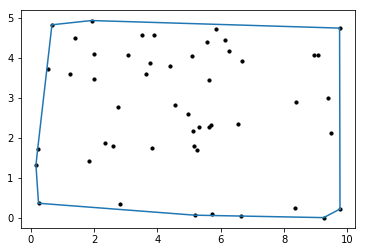

In [6]:
def build_hull(xdata, ydata):
    
    data = np.zeros(xdata.size*2).reshape(xdata.size,2)

    data[:,0] = xdata
    data[:,1] = ydata

    hull = ConvexHull(data)

    return hull

def get_closed_vertices(vertices_list):
    vertices_list_closed = np.append(vertices_list, vertices_list[0])
    return vertices_list_closed

hull_example_xdata = np.array(10.*np.random.rand(50))
hull_example_ydata = np.array(5.*np.random.rand(50))

#Build the hull
example_hull = build_hull(hull_example_xdata, hull_example_ydata)
#Get the closed loop of vertices to plot
example_closed_verts = get_closed_vertices(example_hull.vertices)

plt.scatter(hull_example_xdata, hull_example_ydata, s=10, c='k')
plt.plot(hull_example_xdata[example_closed_verts], hull_example_ydata[example_closed_verts])
plt.show()

With all of these steps put in place, we can now start cutting our list down to size. Let's start with the somewhat straightforward things: objects that are clearly too blue to be M dwarfs in their raw data, and Be stars. To cut the early-type objects, we'll cut anything with an (H-K) value below 0.175. To cut whatever Be stars are left after that cut, we'll also remove objects with a (J-K) value below 0.8.

In [7]:
raw_early_list = []
no_raw_earlies_list = []

for obj in object_list:
    if (obj.hmink < 0.175):
        raw_early_list.append(obj)
    else:
        no_raw_earlies_list.append(obj)
        
print "After early star cut:", len(no_raw_earlies_list)

raw_Bes_list = []
no_raw_Bes_list = []

for obj in no_raw_earlies_list:
    if (obj.jmink < 0.75):
        raw_Bes_list.append(obj)
    else:
        no_raw_Bes_list.append(obj)
        
print "After Be star cut:", len(no_raw_Bes_list)

After early star cut: 14591
After Be star cut: 14300


Let's now plot what we have done so far. We'll draw a heatmap of the initial target set that we just cut from (in raw (J-H) vs (H-K) space), and draw the regions that got removed based on the convex hull of the objects that got removed. We'll use our vector-generating function to get the relevant vectors, even though we don't need all the vectors that that function generates right now. We'll all draw an ''after'' heatmap to indicate what the remaining sample looks like.

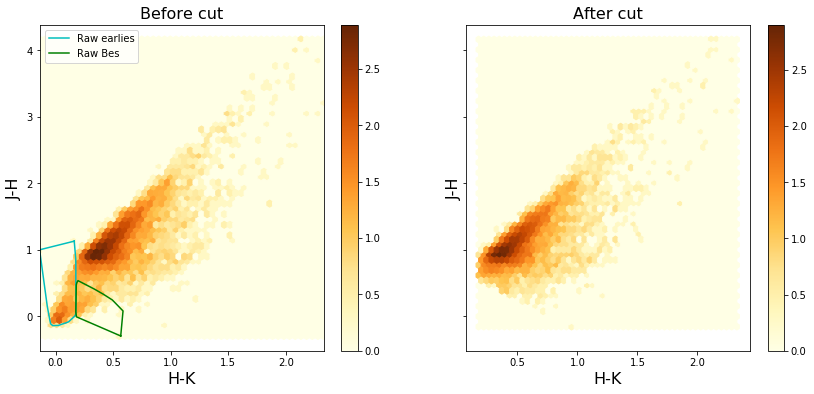

In [8]:
objects_jminh, objects_hmink, objects_jmink, objects_w1minw2, objects_w2minw3, objects_jminh_dereddened, objects_hmink_dereddened, objects_jmink_dereddened, objects_w1minw2_dereddened = get_vecs(object_list)
raw_earlies_jminh, raw_earlies_hmink, raw_earlies_jmink, raw_earlies_w1minw2, raw_earlies_w2minw3, raw_earlies_jminh_dereddened, raw_earlies_hmink_dereddened, raw_earlies_jmink_dereddened, raw_earlies_w1minw2_dereddened = get_vecs(raw_early_list)
raw_Bes_jminh, raw_Bes_hmink, raw_Bes_jmink, raw_Bes_w1minw2, raw_Bes_w2minw3, raw_Bes_jminh_dereddened, raw_Bes_hmink_dereddened, raw_Bes_jmink_dereddened, raw_Bes_w1minw2_dereddened = get_vecs(raw_Bes_list)
no_raw_Bes_jminh, no_raw_Bes_hmink, no_raw_Bes_jmink, no_raw_Bes_w1minw2, no_raw_Bes_w2minw3, no_raw_Bes_jminh_dereddened, no_raw_Bes_hmink_dereddened, no_raw_Bes_jmink_dereddened, no_raw_Bes_w1minw2_dereddened = get_vecs(no_raw_Bes_list)

raw_earlies_hull = build_hull(raw_earlies_hmink, raw_earlies_jminh)
raw_Bes_hull = build_hull(raw_Bes_hmink, raw_Bes_jminh)

raw_earlies_closed = get_closed_vertices(raw_earlies_hull.vertices)
raw_Bes_closed = get_closed_vertices(raw_Bes_hull.vertices)

#Generate heatmap
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(14,6))
im = ax1.hexbin(objects_hmink, objects_jminh, gridsize=50, bins='log', cmap='YlOrBr',vmin=0.)
f.colorbar(im, ax=ax1)

ax1.plot(raw_earlies_hmink[raw_earlies_closed], raw_earlies_jminh[raw_earlies_closed], 'c', label='Raw earlies')
ax1.plot(raw_Bes_hmink[raw_Bes_closed], raw_Bes_jminh[raw_Bes_closed], 'g', label='Raw Bes')

ax1.set_xlabel('H-K', fontsize=16)
ax1.set_ylabel('J-H', fontsize=16)
ax1.legend(loc='upper left')
ax1.set_title('Before cut', fontsize=16)

im1 = ax2.hexbin(no_raw_Bes_hmink, no_raw_Bes_jminh, gridsize=50, bins='log', cmap='YlOrBr',vmin=0.)
f.colorbar(im1, ax=ax2)
ax2.set_xlabel('H-K', fontsize=16)
ax2.set_ylabel('J-H', fontsize=16)
ax2.set_title('After cut', fontsize=16)
plt.show()

Now let's get rid of the things that are clearly early-type when de-reddened. Remember, however, that if the reddening correction for an object is too high, we'll be treating the raw value as the de-reddened value. We should also remember that we've already removed a set of objects (the raw earlies and raw Bes), so this cut will only apply to the remainder from that. As such, our heatmap will be of the remaining objects after that cut.

After dereddened early star cut: 14062
After dereddened Be star cut: 13442


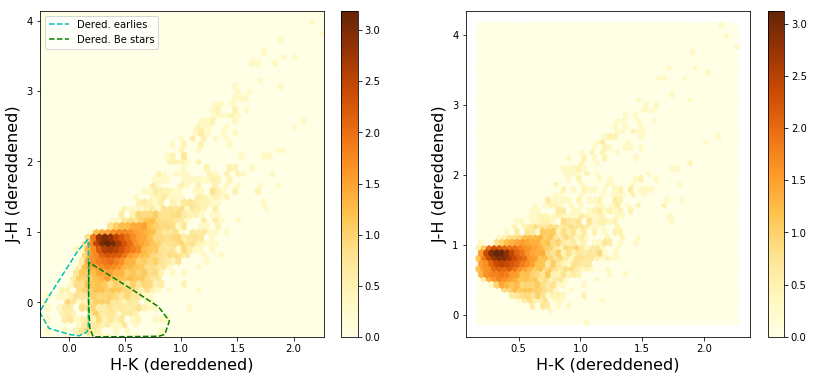

In [9]:
dereddened_early_list = []
no_earlies_list = []

for obj in no_raw_Bes_list:
    if (obj.hmink_dereddened_use < 0.175):
        dereddened_early_list.append(obj)
    else:
        no_earlies_list.append(obj)
        
print "After dereddened early star cut:", len(no_earlies_list)

dereddened_Bes_list = []
no_Bes_list = []

for obj in no_earlies_list:
    if (obj.jmink_dereddened_use < 0.75):
        dereddened_Bes_list.append(obj)
    else:
        no_Bes_list.append(obj)
        
print "After dereddened Be star cut:", len(no_Bes_list)


dered_earlies_jminh, dered_earlies_hmink, dered_earlies_jmink, dered_earlies_w1minw2, dered_earlies_w2minw3, dered_earlies_jminh_dereddened, dered_earlies_hmink_dereddened, dered_earlies_jmink_dereddened, dered_earlies_w1minw2_dereddened = get_vecs(dereddened_early_list)
dered_Bes_jminh, dered_Bes_hmink, dered_Bes_jmink, dered_Bes_w1minw2, dered_Bes_w2minw3, dered_Bes_jminh_dereddened, dered_Bes_hmink_dereddened, dered_Bes_jmink_dereddened, dered_Bes_w1minw2_dereddened = get_vecs(dereddened_Bes_list)
no_Bes_jminh, no_Bes_hmink, no_Bes_jmink, no_Bes_w1minw2, no_Bes_w2minw3, no_Bes_jminh_dereddened, no_Bes_hmink_dereddened, no_Bes_jmink_dereddened, no_Bes_w1minw2_dereddened = get_vecs(no_Bes_list)

dered_earlies_hull = build_hull(dered_earlies_hmink_dereddened, dered_earlies_jminh_dereddened)
dered_Bes_hull = build_hull(dered_Bes_hmink_dereddened, dered_Bes_jminh_dereddened)

dered_earlies_closed = get_closed_vertices(dered_earlies_hull.vertices)
dered_Bes_closed = get_closed_vertices(dered_Bes_hull.vertices)

#Generate heatmap
f1, (ax3, ax4) = plt.subplots(1, 2, figsize=(14,6))
im2 = ax3.hexbin(no_raw_Bes_hmink_dereddened, no_raw_Bes_jminh_dereddened, gridsize=50, bins='log', cmap='YlOrBr',vmin=0.)
f1.colorbar(im2, ax=ax3)

ax3.plot(dered_earlies_hmink_dereddened[dered_earlies_closed], dered_earlies_jminh_dereddened[dered_earlies_closed], 'c--', label='Dered. earlies')
ax3.plot(dered_Bes_hmink_dereddened[dered_Bes_closed], dered_Bes_jminh_dereddened[dered_Bes_closed], 'g--', label='Dered. Be stars')

ax3.set_xlabel('H-K (dereddened)', fontsize=16)
ax3.set_ylabel('J-H (dereddened)', fontsize=16)
ax3.legend(loc='upper left')

im3 = ax4.hexbin(no_Bes_hmink_dereddened, no_Bes_jminh_dereddened, gridsize=50, bins='log', cmap='YlOrBr', vmin=0.)
f1.colorbar(im3, ax=ax4)

ax4.set_xlabel('H-K (dereddened)', fontsize=16)
ax4.set_ylabel('J-H (dereddened)', fontsize=16)

plt.show()

Of note, in this dereddened space M giants appear to be more concentrated than they were in unreddened space. We can use that to our advantage when cutting for M dwarfs, which we will do now.

[Covey et al. (2007)](http://iopscience.iop.org/article/10.1086/522052/meta) showed that in SDSS _(g-i)_ space, the boundary between a spectral type of K7 and M0 is between _(g-i)_ = 1.75 and _(g-i)_ = 1.98. This paper also shows that (H-K) exhibits roughly monotonic behavior with increasing _(g-i)_. As such, we can use (H-K) color as a proxy here--which we did when cutting things based on (H-K) color earlier.

[Bessell & Brett (1988)](http://dx.doi.org/10.1086/132281) showed that M giants and M dwarfs bifurcate in (J-H) vs (H-K) space, though their work did not use 2MASS filters. To translate this to 2MASS filters, we look at the (J-H) vs _(g-i)_ data from Covey et al. (2007), finding that the local maximum before the "dip" in (J-H) occurs at a (J-H) value of approximately $0.66 \pm 0.05$. Similarly, the local minimum of the "dip" is at $0.58 \pm 0.06$. Allowing for approximately $3 \sigma$ above the maximum and below the minimum to catch any potential stragglers, we define an M dwarf region in (J-H) space as:

$0.4 \leq (J-H) \leq 0.8$.

We thus cut out a set of objects based solely on this (J-H) cut. This is most likely to have straggling M giants at the blue end (approximately M0), but interloping giants are bound to happen regardless. We perform this cut solely on dereddened colors, to avoid eliminating apparent M giants that are revealed to be dust-obscured M dwarfs.

M dwarfs selected: 4180
Backup M dwarfs: 191
0.4 3.071
55


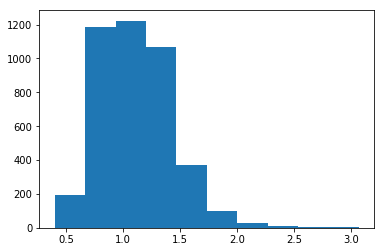

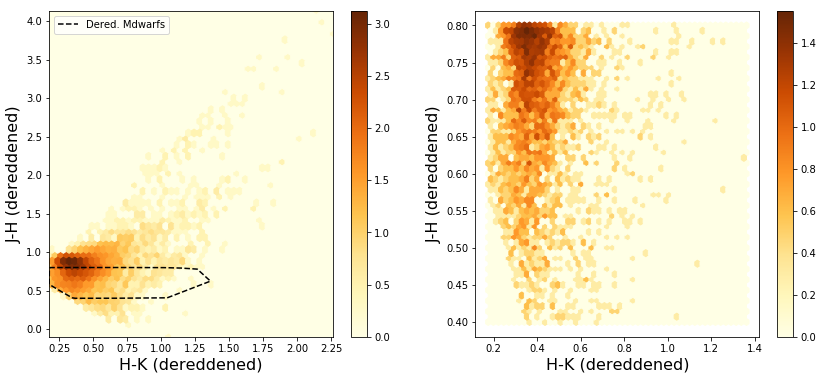

In [10]:
mdwarfs_initial_cut = []
not_initial_cut_mdwarfs = []
secondary_mdwarfs = []

for obj in no_Bes_list:
    if (obj.jminh_dereddened_use >= 0.4) and (obj.jminh_dereddened_use <= 0.8):
        mdwarfs_initial_cut.append(obj)
    elif (obj.jminh_dereddened_use < 0.4):
        secondary_mdwarfs.append(obj)
    else:
        not_initial_cut_mdwarfs.append(obj)
        
print "M dwarfs selected:", len(mdwarfs_initial_cut)
print "Backup M dwarfs:", len(secondary_mdwarfs)
        
firstcut_mdwarfs_jminh, firstcut_mdwarfs_hmink, firstcut_mdwarfs_jmink, firstcut_mdwarfs_w1minw2, firstcut_mdwarfs_w2minw3, firstcut_mdwarfs_jminh_dereddened, firstcut_mdwarfs_hmink_dereddened, firstcut_mdwarfs_jmink_dereddened, firstcut_mdwarfs_w1minw2_dereddened = get_vecs(mdwarfs_initial_cut)
secondary_mdwarfs_jminh, secondary_mdwarfs_hmink, secondary_mdwarfs_jmink, secondary_mdwarfs_w1minw2, secondary_mdwarfs_w2minw3, secondary_mdwarfs_jminh_dereddened, secondary_mdwarfs_hmink_dereddened, secondary_mdwarfs_jmink_dereddened, secondary_mdwarfs_w1minw2_dereddened = get_vecs(mdwarfs_initial_cut)

print min(secondary_mdwarfs_jminh), max(secondary_mdwarfs_jminh)

secondary_mdwarfs_keep = [o for o in secondary_mdwarfs if o.jminh >= 0.4 and o.jminh <=0.8]

print len(secondary_mdwarfs_keep)

plt.hist(secondary_mdwarfs_jminh)
plt.show()

firstcut_mdwarfs_hull = build_hull(firstcut_mdwarfs_hmink_dereddened, firstcut_mdwarfs_jminh_dereddened)
firstcut_mdwarfs_closed = get_closed_vertices(firstcut_mdwarfs_hull.vertices)


#Generate heatmap
f2, (ax5, ax6) = plt.subplots(1, 2, figsize=(14 ,6))
im4 = ax5.hexbin(no_Bes_hmink_dereddened, no_Bes_jminh_dereddened, gridsize=50, bins='log', cmap='YlOrBr',vmin=0.)
f2.colorbar(im4, ax=ax5)

ax5.plot(firstcut_mdwarfs_hmink_dereddened[firstcut_mdwarfs_closed], firstcut_mdwarfs_jminh_dereddened[firstcut_mdwarfs_closed], 'k--', label='Dered. Mdwarfs')

ax5.set_xlabel('H-K (dereddened)', fontsize=16)
ax5.set_ylabel('J-H (dereddened)', fontsize=16)
ax5.legend(loc='upper left')

im5 = ax6.hexbin(firstcut_mdwarfs_hmink_dereddened, firstcut_mdwarfs_jminh_dereddened, gridsize=50, bins='log', cmap='YlOrBr', vmin=0.)
f2.colorbar(im5, ax=ax6)

ax6.set_xlabel('H-K (dereddened)', fontsize=16)
ax6.set_ylabel('J-H (dereddened)', fontsize=16)

plt.show()

plt.figure()
plt.hexbin(no_raw_Bes_hmink_dereddened, no_raw_Bes_jminh_dereddened, gridsize=50, bins='log', cmap='YlOrBr',vmin=0.)
plt.colorbar()

plt.plot(dered_earlies_hmink_dereddened[dered_earlies_closed], dered_earlies_jminh_dereddened[dered_earlies_closed], 'c--', label='Dered. earlies')
plt.plot(dered_Bes_hmink_dereddened[dered_Bes_closed], dered_Bes_jminh_dereddened[dered_Bes_closed], 'g--', label='Dered. Be stars')
plt.plot(firstcut_mdwarfs_hmink_dereddened[firstcut_mdwarfs_closed], firstcut_mdwarfs_jminh_dereddened[firstcut_mdwarfs_closed], 'k--', label='Dered. Mdwarfs')

plt.xlabel('H-K (dereddened)', fontsize=18)
plt.ylabel('J-H (dereddened)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

plt.legend(loc='upper left')
plt.savefig('Mdwarf_initial_selection_cuts.png')


We see that of the 191 objects in the "purgatory" region below the color cut, 55 have raw colors consistent with M dwarfs. Let's add those back in. 

In [11]:
mdwarfs_revised_cut = mdwarfs_initial_cut + [o for o in secondary_mdwarfs_keep if o not in mdwarfs_initial_cut]

#mdwarfs_revised_cut = list(mdwarfs_initial_cut)

print len(mdwarfs_revised_cut)

4235


Now that we have things that appear to be photospherically M dwarfs (or at least photospherically not M giants), let's work on making sure that they actually have debris disks, rather than being YSOs or bare M dwarfs.

[Koenig & Leisawitz 2014](http://dx.doi.org/10.1088/0004-637X/791/2/131) assembled a series of color cuts to identify YSOs in AllWISE. Significantly, despite looking through interstellar dust, these cuts rely on the _raw_ data only. As such, we will, as well.

Rather than assemble each of their cuts in the main flow of code, we will instead write a function for each one to get all of the objects that meet the criteria of that cut, and then remove those objects from what remains of our sample. To make _that_ easier, we will also write a function to remove a given cut from our larger sample. Let's start with that function.

In [12]:
def cut_object_list(object_dict, object_list, list_to_cut):
    object_wiseids = [o.wiseid for o in object_list]
    cut_wiseids = [o.wiseid for o in list_to_cut]

    remain_wiseids = [x for x in object_wiseids if x not in cut_wiseids]

    remain_objs = [object_dict[x] for x in remain_wiseids]
   
    return remain_objs

Just to be on the safe side, let's start with eliminating extragalactic objects. In theory this should be addressed by website classifications and the $J < 14.5$ cut we put on the list we began with, but it wouldn't hurt to check again. This set of functions will find and eliminate any star-forming galaxies and AGN.

In [13]:
def get_star_forming_galaxies(object_list):
    qualifier_one_list = []
    qualifier_two_list = []
    qualifier_three_list = []
    final_list = []
    
    for obj in object_list:
        if obj.w2minw3_dereddened_use > 2.3:
            qualifier_one_list.append(obj)
            
    for obj1 in qualifier_one_list:
        if obj1.w1minw2_dereddened_use < 1.:
            qualifier_two_list.append(obj1)
            
    for obj2 in qualifier_two_list:
        if obj2.w1minw2_dereddened_use < ((0.46*(obj2.w2minw3_dereddened_use)) - 0.78):
            #qualifier_three_list.append(obj2)
            final_list.append(obj2)
            
    #for obj3 in qualifier_three_list:
    #    if obj3.w1mag_dereddened > 13.0:
    #        final_list.append(obj3)
            
    return final_list

sfg_list = get_star_forming_galaxies(mdwarfs_revised_cut)
no_sfg_targets = cut_object_list(obj_dict, mdwarfs_revised_cut, sfg_list)

print 'Remaining targets after SFG cuts:', len(no_sfg_targets)

def get_AGNs(object_list):
    AGN_list = []
    #list_two = []
    
    for obj in object_list:
        if (obj.w1mag_dereddened_use > 13) and (obj.w1mag_dereddened_use > ((1.8*(obj.w1mag_dereddened_use - obj.w3mag_dereddened_use)) + 4.1)):
            AGN_list.append(obj)
        
        elif (obj.w1mag_dereddened_use > ((obj.w1mag_dereddened_use - obj.w3mag_dereddened_use) + 11.)):
            AGN_list.append(obj)
            
    return AGN_list

AGN_list = get_AGNs(no_sfg_targets)
no_galaxy_targets = cut_object_list(obj_dict, no_sfg_targets, AGN_list)

print 'Remaining targets after extragalactic cuts:', len(no_galaxy_targets)

Remaining targets after SFG cuts: 3989
Remaining targets after extragalactic cuts: 3988


We now identify and select away likely YSOs. It is important to note that while we will adopt the Koenig & Leisawitz (2014) cuts for Class I and Class II YSOs, we will not adopt the W4-based cuts, as eliminating transitional disks could also end up eliminating some debris-like things that we're interested in.

After WISE Class I cut: 3908
After WISE Class II cut: 2910


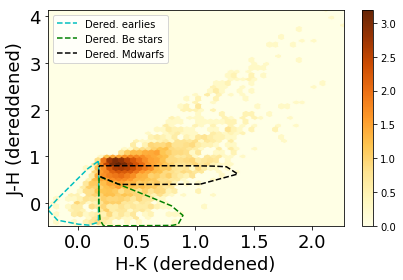

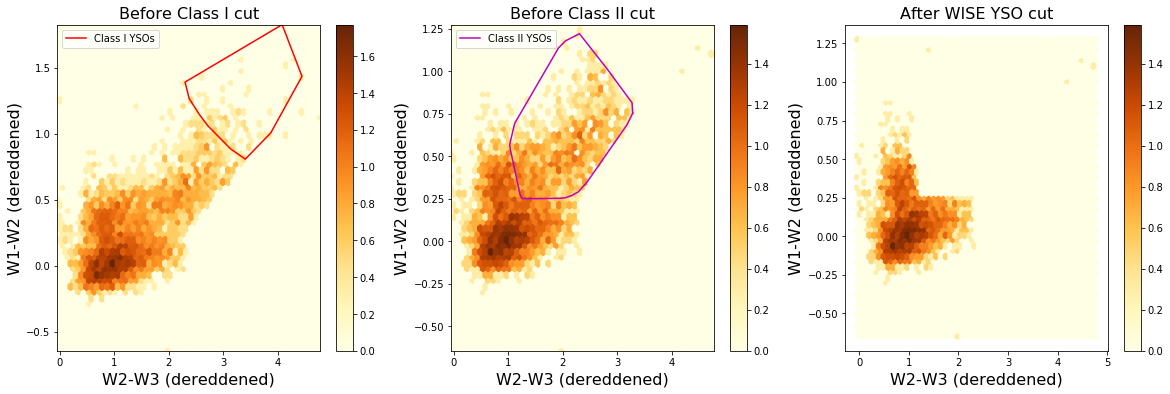

In [14]:
def get_class_ones(object_list):
    qualifier_one_list = []
    qualifier_two_list = []
    qualifier_three_list = []
    final_list = []
    
    for obj in object_list:
        if (obj.w2minw3_dereddened_use) > 2.0:
            qualifier_one_list.append(obj)
            
    for obj1 in qualifier_one_list:
        if obj1.w1minw2_dereddened_use > ((-0.42*obj1.w2minw3_dereddened_use) + 2.2):
            qualifier_two_list.append(obj1)
            
    for obj2 in qualifier_two_list:
        if obj2.w1minw2_dereddened_use > ((0.46*obj2.w2minw3_dereddened_use) - 0.9):
            qualifier_three_list.append(obj2)
            
    for obj3 in qualifier_three_list:
        if obj3.w2minw3_dereddened_use < 4.5:
            final_list.append(obj3)
            
    return final_list

wise_class_ones = get_class_ones(no_galaxy_targets)
no_wise_class_ones = cut_object_list(obj_dict, no_galaxy_targets, wise_class_ones)

print 'After WISE Class I cut:', len(no_wise_class_ones)

def get_class_twos(object_list):
    qualifier_one_list = []
    qualifier_two_list = []
    qualifier_three_list = []
    qualifier_four_list = []
    final_list = []
    
    for obj in object_list:
        if obj.w1minw2_dereddened_use > 0.25:
            qualifier_one_list.append(obj)
            
    for obj1 in qualifier_one_list:
        if obj1.w1minw2_dereddened_use < ((0.9*(obj1.w2minw3_dereddened_use)) - 0.25):
            qualifier_two_list.append(obj1)
            
    for obj2 in qualifier_two_list:
        if obj2.w1minw2_dereddened_use > ((-1.5*(obj2.w2minw3_dereddened_use)) + 2.1):
            qualifier_three_list.append(obj2)
            
    for obj3 in qualifier_three_list:
        if obj3.w1minw2_dereddened_use > ((0.46 * (obj3.w2minw3_dereddened_use)) - 0.9):
            qualifier_four_list.append(obj3)
            
    for obj4 in qualifier_four_list:
        if (obj4.w2minw3_dereddened_use) < 4.5:
            final_list.append(obj4)
            
    return final_list

wise_class_twos = get_class_twos(no_wise_class_ones)
no_wise_ysos = cut_object_list(obj_dict, no_wise_class_ones, wise_class_twos)

print 'After WISE Class II cut:', len(no_wise_ysos)

no_galaxies_jminh, no_galaxies_hmink, no_galaxies_jmink, no_galaxies_w1minw2, no_galaxies_w2minw3, no_galaxies_jminh_dereddened, no_galaxies_hmink_dereddened, no_galaxies_jmink_dereddened, no_galaxies_w1minw2_dereddened = get_vecs(no_galaxy_targets)
wise_classones_jminh, wise_classones_hmink, wise_classones_jmink, wise_classones_w1minw2, wise_classones_w2minw3, wise_classones_jminh_dereddened, wise_classones_hmink_dereddened, wise_classones_jmink_dereddened, wise_classones_w1minw2_dereddened = get_vecs(wise_class_ones)
no_wise_classones_jminh, no_wise_classones_hmink, no_wise_classones_jmink, no_wise_classones_w1minw2, no_wise_classones_w2minw3, no_wise_classones_jminh_dereddened, no_wise_classones_hmink_dereddened, no_wise_classones_jmink_dereddened, no_wise_classones_w1minw2_dereddened = get_vecs(no_wise_class_ones)
wise_classtwos_jminh, wise_classtwos_hmink, wise_classtwos_jmink, wise_classtwos_w1minw2, wise_classtwos_w2minw3, wise_classtwos_jminh_dereddened, wise_classtwos_hmink_dereddened, wise_classtwos_jmink_dereddened, wise_classtwos_w1minw2_dereddened = get_vecs(wise_class_twos)
no_wise_ysos_jminh, no_wise_ysos_hmink, no_wise_ysos_jmink, no_wise_ysos_w1minw2, no_wise_ysos_w2minw3, no_wise_ysos_jminh_dereddened, no_wise_ysos_hmink_dereddened, no_wise_ysos_jmink_dereddened, no_wise_ysos_w1minw2_dereddened = get_vecs(no_wise_ysos)

no_galaxies_w2minw3_dereddened = np.array([o.w2minw3_dereddened_use for o in no_galaxy_targets])
wise_classones_w2minw3_dereddened = np.array([o.w2minw3_dereddened_use for o in wise_class_ones])
no_wise_classones_w2minw3_dereddened = np.array([o.w2minw3_dereddened_use for o in no_wise_class_ones])
wise_classtwos_w2minw3_dereddened = np.array([o.w2minw3_dereddened_use for o in wise_class_twos])
no_wise_ysos_w2minw3_dereddened = np.array([o.w2minw3_dereddened_use for o in no_wise_ysos])

wise_classones_hull = build_hull(wise_classones_w2minw3_dereddened, wise_classones_w1minw2_dereddened)
wise_classones_closed = get_closed_vertices(wise_classones_hull.vertices)

wise_classtwos_hull = build_hull(wise_classtwos_w2minw3_dereddened, wise_classtwos_w1minw2_dereddened)
wise_classtwos_closed = get_closed_vertices(wise_classtwos_hull.vertices)

f3, (ax7, ax8, ax9) = plt.subplots(1, 3, figsize=(20, 6))
im6 = ax7.hexbin(no_galaxies_w2minw3_dereddened, no_galaxies_w1minw2_dereddened, gridsize=50, bins='log', cmap='YlOrBr',vmin=0.)
f3.colorbar(im6, ax=ax7)

ax7.plot(wise_classones_w2minw3_dereddened[wise_classones_closed], wise_classones_w1minw2_dereddened[wise_classones_closed], 'r', label='Class I YSOs')

ax7.set_xlabel('W2-W3 (dereddened)', fontsize=16)
ax7.set_ylabel('W1-W2 (dereddened)', fontsize=16)
ax7.legend(loc='upper left')
ax7.set_title('Before Class I cut', fontsize=16)

im7 = ax8.hexbin(no_wise_classones_w2minw3_dereddened, no_wise_classones_w1minw2_dereddened, gridsize=50, bins='log', cmap='YlOrBr', vmin=0.)
f3.colorbar(im7, ax=ax8)

ax8.plot(wise_classtwos_w2minw3_dereddened[wise_classtwos_closed], wise_classtwos_w1minw2_dereddened[wise_classtwos_closed], 'm', label='Class II YSOs')

ax8.set_xlabel('W2-W3 (dereddened)', fontsize=16)
ax8.set_ylabel('W1-W2 (dereddened)', fontsize=16)
ax8.legend(loc='upper left')
ax8.set_title('Before Class II cut', fontsize=16)

im8 = ax9.hexbin(no_wise_ysos_w2minw3_dereddened, no_wise_ysos_w1minw2_dereddened, gridsize=50, bins='log', cmap='YlOrBr', vmin=0.)
f3.colorbar(im8, ax=ax9)

ax9.set_xlabel('W2-W3 (dereddened)', fontsize=16)
ax9.set_ylabel('W1-W2 (dereddened)', fontsize=16)
#ax9.legend(loc='upper left')
ax9.set_title('After WISE YSO cut', fontsize=16)

plt.show()

plt.figure()
plt.hexbin(no_galaxies_w2minw3_dereddened, no_galaxies_w1minw2_dereddened, gridsize=50, bins='log', cmap='YlOrBr',vmin=0.)
plt.colorbar()

plt.plot(wise_classones_w2minw3_dereddened[wise_classones_closed], wise_classones_w1minw2_dereddened[wise_classones_closed], 'r', label='Class I YSOs')
plt.plot(wise_classtwos_w2minw3_dereddened[wise_classtwos_closed], wise_classtwos_w1minw2_dereddened[wise_classtwos_closed], 'm', label='Class II YSOs')
plt.legend(loc='lower right')

plt.xlabel('W2-W3 (dereddened)', fontsize=18)
plt.ylabel('W1-W2 (dereddened)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

plt.savefig('WISE_YSO_cuts.png')

plt.figure()

xvec = [0., 1.]
yvec = [0., 0.8]

plt.plot(xvec,yvec)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()

plt.savefig('get_numbers.png')

Now that we've eliminated the YSOs, let's take a look at whether or not we've truly eliminated M giants. Specifically, let's look at these things in the dereddened (J-K) vs (W1-W2) space that [Li et al. 2016](http://dx.doi.org/10.3847/0004-637X/823/1/59) hunted for M giants in.

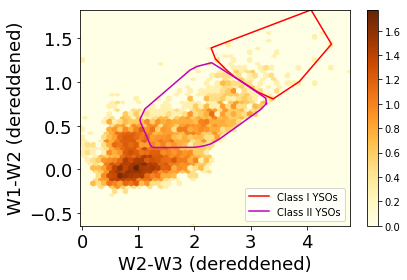

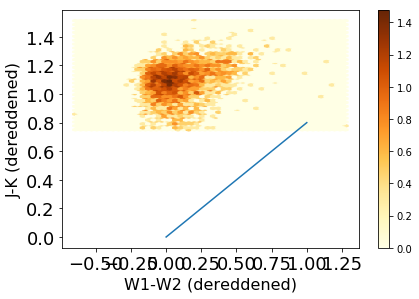

In [15]:
#plt.figure()
plt.hexbin(no_wise_ysos_w1minw2_dereddened, no_wise_ysos_jmink_dereddened,gridsize=50, bins='log', cmap='YlOrBr', vmin=0.)
plt.colorbar()

plt.xlabel('W1-W2 (dereddened)', fontsize=16)
plt.ylabel('J-K (dereddened)', fontsize=16)
plt.show()

Not bad, but we can probably clean this up a bit more, too. We also have an odd blue straggler that wasn't removed by our previous cuts, curiously enough. Let's find out about it.

In [16]:
straggler_wiseid_list = [o.wiseid for o in no_wise_ysos if o.w1minw2_dereddened < -0.4]
straggler_wiseid = straggler_wiseid_list[0]

print straggler_wiseid
straggler = obj_dict[straggler_wiseid]
print straggler.zooniverse_id
print straggler.jminh, straggler.hmink, straggler.jmink, straggler.w1minw2, straggler.w2minw3
print straggler.jmag, straggler.hmag, straggler.kmag, straggler.w1mag, straggler.w2mag, straggler.w3mag

J210129.34+770237.3
AWI0005c0f
0.826 0.53 1.356 -0.634 1.687
9.919 9.093 8.563 7.103 7.737 6.05


Fascinating! We seem to have identified a W1 drop-_in_, as opposed to our normal W1 drop-_out_. Checking the VizieR page for this subject shows that those are in fact the numbers as registered in AllWISE. The WISE All-Sky magnitude, however, is a much more reasonable 8.165, which yields a W1-W2 color of 0.428. We thus will adopt it. Checking this object against the cuts we've made so far, it runs afoul of the Class II YSO cut. So let's go ahead and remove it from the list.

In [17]:
no_ysos_list_use = [o for o in no_wise_ysos if o.wiseid != straggler_wiseid]

print 'Number remaining:', len(no_ysos_list_use)

Number remaining: 2909


Back to our previously scheduled cuts...

[Davenport et al. 2014](http://dx.doi.org/10.1093/mnras/stu466) produced the main-sequence stellar locus traced by SDSS, 2MASS, and WISE (an extension of Covey et al. 2007). We can use their W1-W2 colors to help tighten this selection up.

Using the Covey et al. estimate that the transition between spectral types K7 and M0 is between an SDSS (_g-i_) value of 1.75 and 1.98, we state that our cut-off will be for targets with $(g-i) > 1.85$. After comparing with Table 2 of Davenport et al. (2014), this  corresponds to $(W1-W2) >= -0.001 \pm 0.032$. We therefore set our truncation as $(W1-W2) >= -0.1$. We should also, however, truncate on the red end as well, setting our truncation as $(W1-W2) <= 0.315$, based on Table 2 from Davenport et al. (2014).

We'll also apply the Li et al. (2016) M giant selection criterion, just to clean those few things away as well.

Remaining after WISE straggler cut: 2431


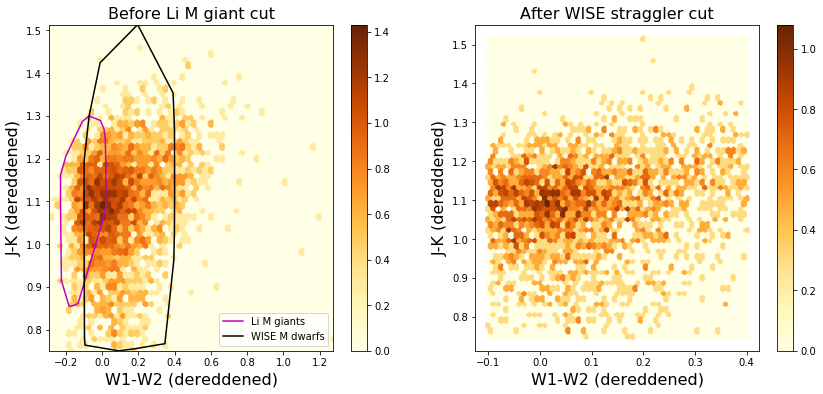

In [18]:
def get_li_mgiants(object_list):
    #qualifier_one_list = []
    #qualifier_two_list = []
    #qualifier_three_list = []
    #qualifier_four_list = []
    final_list = []
    
    qualifier_one_list = [o for o in object_list if ((o.w1minw2_dereddened > -0.23) and (o.w1minw2_dereddened < 0.02))]
    qualifier_two_list = [o for o in qualifier_one_list if ((o.jmink_dereddened < 1.3) and (o.jmink_dereddened > 0.85))]
    final_list = [o for o in qualifier_two_list if (o.jmink_dereddened > ((1.45*o.w1minw2_dereddened) + 1.05))]
    
    return final_list

li_mgiants = get_li_mgiants(no_ysos_list_use)
#no_li_mgiants = cut_object_list(obj_dict, no_ysos_list_use, li_mgiants)

#print 'Remaining after Li M giant cut:', len(no_li_mgiants)

#wise_blue_stragglers = [o for o in no_li_mgiants if o.w1minw2_dereddened < -0.1]
wise_mdwarfs = [o for o in no_ysos_list_use if o.w1minw2_dereddened >=-0.1 and o.w1minw2_dereddened <= 0.4]

print 'Remaining after WISE straggler cut:', len(wise_mdwarfs)

no_ysos_use_jminh, no_ysos_use_hmink, no_ysos_use_jmink, no_ysos_use_w1minw2, no_ysos_use_w2minw3, no_ysos_use_jminh_dereddened, no_ysos_use_hmink_dereddened, no_ysos_use_jmink_dereddened, no_ysos_use_w1minw2_dereddened = get_vecs(no_ysos_list_use)
li_mgiants_jminh, li_mgiants_hmink, li_mgiants_jmink, li_mgiants_w1minw2, li_mgiants_w2minw3, li_mgiants_jminh_dereddened, li_mgiants_hmink_dereddened, li_mgiants_jmink_dereddened, li_mgiants_w1minw2_dereddened = get_vecs(li_mgiants)
#no_li_mgiants_jminh, no_li_mgiants_hmink, no_li_mgiants_jmink, no_li_mgiants_w1minw2, no_li_mgiants_w2minw3, no_li_mgiants_jminh_dereddened, no_li_mgiants_hmink_dereddened, no_li_mgiants_jmink_dereddened, no_li_mgiants_w1minw2_dereddened = get_vecs(no_li_mgiants)
#wise_straggler_jminh, wise_straggler_hmink, wise_straggler_jmink, wise_straggler_w1minw2, wise_straggler_w2minw3, wise_straggler_jminh_dereddened, wise_straggler_hmink_dereddened, wise_straggler_jmink_dereddened, wise_straggler_w1minw2_dereddened = get_vecs(wise_stragglers)
wise_mdwarfs_jminh, wise_mdwarfs_hmink, wise_mdwarfs_jmink, wise_mdwarfs_w1minw2, wise_mdwarfs_w2minw3, wise_mdwarfs_jminh_dereddened, wise_mdwarfs_hmink_dereddened, wise_mdwarfs_jmink_dereddened, wise_mdwarfs_w1minw2_dereddened = get_vecs(wise_mdwarfs)

li_mgiants_hull = build_hull(li_mgiants_w1minw2_dereddened, li_mgiants_jmink_dereddened)
li_mgiants_closed = get_closed_vertices(li_mgiants_hull.vertices)

wise_mdwarf_hull = build_hull(wise_mdwarfs_w1minw2_dereddened, wise_mdwarfs_jmink_dereddened)
wise_mdwarf_closed = get_closed_vertices(wise_mdwarf_hull.vertices)

f5, (ax12, ax14) = plt.subplots(1, 2, figsize=(14, 6))
im11 = ax12.hexbin(no_ysos_use_w1minw2_dereddened, no_ysos_use_jmink_dereddened, gridsize=50, bins='log', cmap='YlOrBr',vmin=0.)
f5.colorbar(im11, ax=ax12)

ax12.plot(li_mgiants_w1minw2_dereddened[li_mgiants_closed], li_mgiants_jmink_dereddened[li_mgiants_closed], 'm', label='Li M giants')
ax12.plot(wise_mdwarfs_w1minw2_dereddened[wise_mdwarf_closed], wise_mdwarfs_jmink_dereddened[wise_mdwarf_closed], 'k', label='WISE M dwarfs')

ax12.set_xlabel('W1-W2 (dereddened)', fontsize=16)
ax12.set_ylabel('J-K (dereddened)', fontsize=16)
ax12.legend(loc='lower right')
ax12.set_title('Before Li M giant cut', fontsize=16)

#im12 = ax13.hexbin(no_li_mgiants_w1minw2_dereddened, no_li_mgiants_jmink_dereddened, gridsize=50, bins='log', cmap='YlOrBr', vmin=0.)
#f5.colorbar(im12, ax=ax13)

#ax13.set_xlabel('W1-W2 (dereddened)', fontsize=16)
#ax13.set_ylabel('J-K (dereddened)', fontsize=16)
#ax13.legend(loc='lower right')
#ax13.set_title('Before WISE straggler cut', fontsize=16)

im13 = ax14.hexbin(wise_mdwarfs_w1minw2_dereddened, wise_mdwarfs_jmink_dereddened, gridsize=50, bins='log', cmap='YlOrBr', vmin=0.)
f5.colorbar(im13, ax=ax14)

ax14.set_xlabel('W1-W2 (dereddened)', fontsize=16)
ax14.set_ylabel('J-K (dereddened)', fontsize=16)
#ax9.legend(loc='upper left')
ax14.set_title('After WISE straggler cut', fontsize=16)

plt.show()

While we've mostly gotten rid of YSOs, there will still be a few things that have excesses that are clearly too strong to be debris disks. There's also going to be a fair few objects that have photospheric emission that was originally caught in the initial data selection. Let's take a look at our current (W1-W4) distribution.

Mean W4 excess value: 1.46679679144
Standard deviation: 0.750628086824
Median: 1.421
Median absolute deviation: 0.424


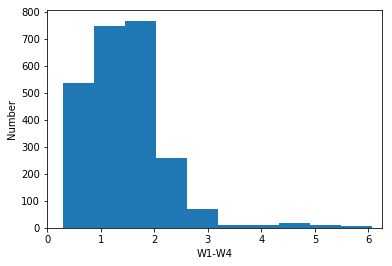

Cutoff: 2.269
Fraction included for upper cutoff of 2.5: 0.935417523653


In [19]:
w4xs_vec = np.array([o.w4xs for o in wise_mdwarfs])

plt.hist(w4xs_vec)
plt.xlabel('W1-W4')
plt.ylabel('Number')
plt.xlim([0.,6.25])

print "Mean W4 excess value:", np.mean(w4xs_vec)
print "Standard deviation:", np.std(w4xs_vec)
print "Median:", np.median(w4xs_vec)

mad_vec = np.zeros(w4xs_vec.size)

for i in range(w4xs_vec.size):
    mad_vec[i] = np.abs(w4xs_vec[i] - np.median(w4xs_vec))
    
print "Median absolute deviation:", np.median(mad_vec)

plt.show()

print "Cutoff:", np.median(w4xs_vec) + 2.*(np.median(mad_vec))

print "Fraction included for upper cutoff of 2.5:", float(len([o.w4xs for o in wise_mdwarfs if o.w4xs <= 2.5]))/float(len(w4xs_vec))

Clearly we have some major outliers here, but for the most part things are nicely settled between 0.25 and 3, as we might expect. However, some of these are almost certainly photosphere detections, and many of these are far too strong to be debris. So let's weed those out.

We start by checking to see how many of these may be outliers due to a W1 saturation issue. Since the database has AllWISE values for W1, rather than the WISE All-Sky values used by Patel et al. (2014), these values have gone uncorrected (better to leave it alone than to introduce unknown systematics into the situation). So all these excess readings are completely uncorrected. Let's see how many are likely to have saturation issues that need correction.

In [20]:
w1_dropout_potential = [o for o in wise_mdwarfs if o.w1mag < 8.]

print len(w1_dropout_potential)
    

2177


So W1 issues could be affecting the bulk of the sample. Fantastic. This should mostly be mitigated by the Patel et al. correction, but special care should be taken with these. Let's consider the cuts we can attempt in the meantime, using data from observed disk-less M dwarfs to estimate the intrinsic excess as a function of spectral type. We'll use (H-K) value as a proxy for spectral type here.

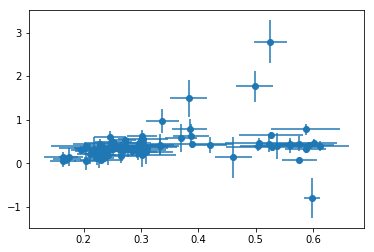

In [21]:
#Read in standard star color data.
#import pandas as pd

mdwarf_standard_df = pd.read_csv('intrinsic_colors.csv')
mdwarf_standard_data = mdwarf_standard_df.values

#print mdwarf_standard_data[:,0].size
mdwarf_standard_hmink = mdwarf_standard_data[:,0].tolist()
mdwarf_standard_hmink_err = mdwarf_standard_data[:,1].tolist()
mdwarf_standard_w4xs = mdwarf_standard_data[:,4].tolist()
mdwarf_standard_w4xs_err = mdwarf_standard_data[:,5].tolist()

plt.errorbar(mdwarf_standard_hmink, mdwarf_standard_w4xs, xerr=mdwarf_standard_hmink_err, yerr=mdwarf_standard_w4xs_err,fmt='o')
plt.show()

That looks like an awful lot of scatter. This isn't that surprising, though--many of the standard M dwarfs are bright enough that potential non-linearity errors come into play in the 2MASS and W1 data, while the fainter ones are faint enough that they only have upper limits at W4.

Let's try a different option. Using the Mamajek 2MASS M dwarf colors and temperatures, we can find the optimal BT-Settl model for each temperature and 2MASS color combination, and use that to estimate the W1-W4 color for each temperature. We can then fit a line to that set of model data.

Let's read in the (H-K) and (W1-W4) data from the BT-Settl models and see what we have. To make sure that we have accurate fits, we'll find the best-fit BT-Settl model for each Mamajek dataset.

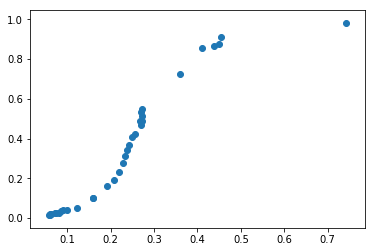

In [69]:
mamajek_df = pd.read_csv('mamajek_to_fit.csv',low_memory=False)
mamajek_data = mamajek_df.values

btsettl_df = pd.read_csv('btsettl_fitting_readin.csv', low_memory=False)
btsettl_data = btsettl_df.values

#print mamajek_data[0,:]
#print btsettl_data[0]

btsettl_dict = {}
#print btsettl_data[:,0].size

for i in range(btsettl_data[:,0].size):
    key_tuple = (btsettl_data[i,0], btsettl_data[i,1])
    btsettl_dict[key_tuple] = btsettl_data[i,2:]

#print btsettl_dict.keys()
#print btsettl_dict[(5777,4.44)]

mamajek_dict = {}
#print mamajek_data[:,0].size

for i in range(mamajek_data[:,0].size):
    dict_key = mamajek_data[i,0]
    init_list = mamajek_data[i,1:].tolist()
    init_list.append(mamajek_data[i,-3]-mamajek_data[i,-2])
    init_list.append(mamajek_data[i,-3]-mamajek_data[i,-1])
    init_list.append(mamajek_data[i,-2]-mamajek_data[i,-1])
    mamajek_vec = np.array(init_list)
    mamajek_dict[dict_key] = mamajek_vec
    
#print mamajek_dict['O3V']
#print mamajek_dict['M0.5V']

mamajek_match_dict = {}
mamajek_residual_dict = {}

for x in mamajek_dict.keys():
    if 'O' in x:
        continue
    elif 'B' in x:
        continue
    elif 'A' in x:
        continue
    else:
        #print x
        test = mamajek_dict[x]
        test_isnan = np.isnan(test)
        num_tested = 0
        best_residual = 0.
        best_residual_name = None
        
        for y in btsettl_dict.keys():
            #print y
            comp = btsettl_dict[y]
            range_check = test_isnan.size == comp.size
            test_use_list = []
            comp_use_list = []
            if range_check:
                for i in range(test_isnan.size):
                    if not test_isnan[i]:
                        test_use_list.append(test[i])
                        comp_use_list.append(comp[i])
                
                test_use_vec = np.array(test_use_list)
                comp_use_vec = np.array(comp_use_list)
                recheck = test_use_vec.size == comp_use_vec.size
                
                dif_vec = test_use_vec - comp_use_vec
                
                squared_vec = np.power(dif_vec,2.)
                sum_squares = np.sum(squared_vec)
                if num_tested < 1:
                    best_residual = sum_squares
                    best_residual_name = y
                else:
                    if sum_squares < best_residual:
                        best_residual = sum_squares
                        best_residual_name = y
                
                num_tested += 1
                    
        
        mamajek_match_dict[x] = best_residual_name
        mamajek_residual_dict[x] = best_residual
        #print x, best_residual_name, best_residual

#for name in mamajek_data[:,0]:
#    if name in mamajek_match_dict.keys():
#        print name, mamajek_match_dict[name], mamajek_residual_dict[name]
    
#print "Done"
#print np.isnan(mamajek_dict['O3V'])

btsettl_wise_readin_df = pd.read_csv('btsettl_wise_data.csv',low_memory=False)
btsettl_wise_data = btsettl_wise_readin_df.values

btsettl_wise_dict = {}
#print btsettl_wise_data[:,0].size
#print btsettl_wise_data[0,2:]

for i in range(btsettl_data[:,0].size):
    key_tuple = (btsettl_wise_data[i,0], btsettl_wise_data[i,1])
    btsettl_test_list = btsettl_wise_data[i,2:].tolist()
    btsettl_test_list.append(btsettl_wise_data[i,2] - btsettl_wise_data[i,-2])
    btsettl_test_list.append(btsettl_wise_data[i,2] - btsettl_wise_data[i,-1])
    btsettl_wise_dict[key_tuple] = np.array(btsettl_test_list)

#print btsettl_wise_dict[(5777.,4.44)]
    
phot_hmink = []
phot_w1minw4 = []

for name in mamajek_data[:,0]:
    if name in mamajek_match_dict.keys():
        if (len(phot_hmink) < 1) or (btsettl_wise_dict[mamajek_match_dict[name]][-1] > phot_w1minw4[-1]):
            phot_hmink.append(btsettl_dict[mamajek_match_dict[name]][-1])
            phot_w1minw4.append(btsettl_wise_dict[mamajek_match_dict[name]][-1])
        
plt.scatter(phot_hmink, phot_w1minw4)
plt.show()


Let's fit a spline to this.

0.222520661157


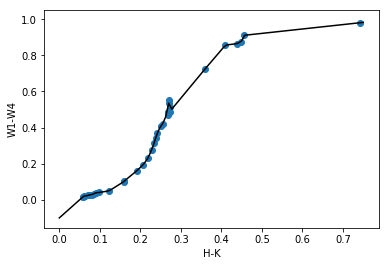

In [79]:
#btsettl_readin_hmink_use = []
#btsettl_readin_w1minw4_use = []

#i=0

#while i < btsettl_readin_hmink.size:
    #print i, btsettl_readin_hmink[i], btsettl_readin_w1minw4[i]
    
    #if i != 211:
        #btsettl_readin_hmink_use.append(btsettl_readin_hmink[i])
        #btsettl_readin_w1minw4_use.append(btsettl_readin_w1minw4[i])

    #i += 1

#print len(btsettl_readin_hmink_use)

plt.scatter(phot_hmink, phot_w1minw4)
#plt.scatter(btsettl_readin_short_hmink, btsettl_readin_short_w1minw4)

#print np.any(btsettl_readin_short_hmink[1:] <= btsettl_readin_short_hmink[:-1])

f_interpolated = interp1d(np.array(phot_hmink), np.array(phot_w1minw4), 'slinear', fill_value='extrapolate')
#f_interpolated_use = interp1d(np.array(btsettl_readin_short_hmink), np.array(btsettl_readin_short_w1minw4), 'slinear')

#test_polyfit = np.polyfit(btsettl_readin_hmink, btsettl_readin_w1minw4, 7)

#print f_interpolated(0.378)

#print test_polyfit
#p = np.poly1d(test_polyfit)

testx = np.linspace(0., 0.75, 101)
#testx_short = np.linspace(min(btsettl_readin_short_hmink), max(btsettl_readin_short_hmink), 101)
plt.plot(testx, f_interpolated(testx), 'k')
#plt.plot(testx_short, f_interpolated_use(testx_short), 'r')
#plt.plot(testx, p(testx),'k')
#plt.plot(0.289, f_interpolated_use(0.289),'ko')
#plt.xlim([0.1, 0.5])
#plt.ylim([0., 2.])

plt.xlabel('H-K')
plt.ylabel('W1-W4')

#print f_interpolated(0.2)
#print f_interpolated(0.25)

testy = f_interpolated(testx)

min_x_use = np.interp(0.25, testy, testx)
print min_x_use

plt.show()

We can now use this spline to get the estimated intrinsic $W1-W4$ value for each object based on its $H-K$ value. So let's apply this. For each object in our field, we'll use our observed H-K value to estimate the W1-W4 value. Since our $H-K$ values have error bars but the spline doesn't, we'll generate 500 distinct $H-K$ values by sampling a normal distribution with mean value equivalent to our observed $H-K$ value, and standard deviation equivalent to the error bars on $H-K$. We'll then get the corresponding value of $W1-W4$ according to our spline relationship for each value, and use them to determine an average $W1-W4$, and a corresponding uncertainty. We'll then subtract the estimated $W1-W4$ from the observed $W1-W4$, propagate forward our uncertainties, and determine if the remaining excess is significant at the $3\sigma$ level.

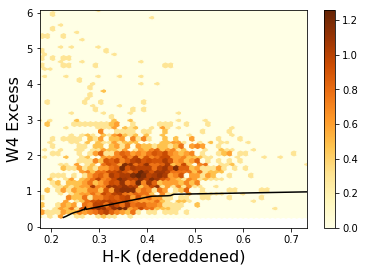

0.42 0.0794795571201
0.333425326433 0.13216509881
0.0865746735667 0.154222609703
0.561361746723
0.175227008575
0.734629431676
0.2891177501 0.0240831891576


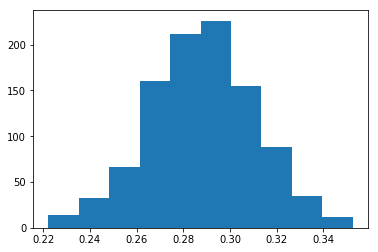

0.533434356594
0.529262819126 0.0691383321081


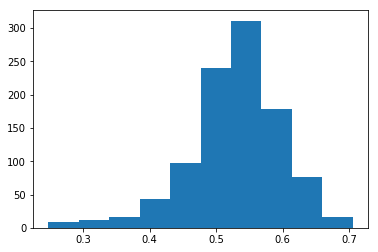

1669


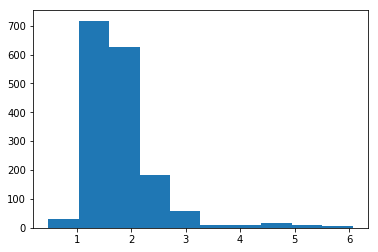

1.16400003433
2431


In [80]:
import time

start_time = time.time()

w4xs_plot_vec = [o.w4xs for o in wise_mdwarfs]
hmink_plot_vec = [o.hmink_dereddened_use for o in wise_mdwarfs]

#min_val_use = find_min_val_use(0.25, 0.2, 0.25)

cutoff_plot_vec = np.linspace(0.225, max(hmink_plot_vec), 301)

plt.hexbin(hmink_plot_vec, w4xs_plot_vec, gridsize=50, bins='log', cmap='YlOrBr', vmin=0.)
plt.plot(cutoff_plot_vec, f_interpolated(cutoff_plot_vec), 'k')
plt.xlabel('H-K (dereddened)', fontsize=16)
plt.ylabel('W4 Excess', fontsize=16)
plt.colorbar()

plt.show()

testhmink = 0.237
testhmink_unc = np.sqrt((0.027**2) + (0.020**2))

hmink_ens = np.random.normal(testhmink, testhmink_unc, 1000)
w1minw4_ens = f_interpolated(hmink_ens)

w1minw4_base = np.mean(w1minw4_ens)
w1minw4_err = np.std(w1minw4_ens)

w1minw4_obs = 0.42
w1minw4_obs_unc = np.sqrt((0.029**2) + (0.074**2))

w4xs = w1minw4_obs - w1minw4_base

w4xs_unc = np.sqrt((w1minw4_err**2) + (w1minw4_obs_unc**2))

w4sig = w4xs/w4xs_unc

print w1minw4_obs, w1minw4_obs_unc
print w1minw4_base, w1minw4_err
print w4xs, w4xs_unc
print w4sig

mdwarfs_winnow_lowend = []

count = 0.

hmink_dereddened_vals = [o.hmink_dereddened_use for o in wise_mdwarfs]
print min(hmink_dereddened_vals)
print max(hmink_dereddened_vals)

for obj in wise_mdwarfs:
    #print count
    obj_hmink_dereddened = obj.hmink_dereddened_use
    obj_hmink_err = obj.hmink_err
    
    #print min(obj_hmink_dereddened), max(obj_hmink_dereddened)
    
    hmink_ensemble = np.random.normal(obj_hmink_dereddened, obj_hmink_err, 1000)
    
    if count < 1.:
        print obj_hmink_dereddened, obj_hmink_err
        plt.hist(hmink_ensemble)
        plt.show()
        print f_interpolated(obj_hmink_dereddened)
    
    w1minw4_ensemble = f_interpolated(hmink_ensemble)
    obj_exp_w4xs = np.mean(w1minw4_ensemble)
    obj_exp_w4xs_err = np.std(w1minw4_ensemble)
    if count < 1.:
        print obj_exp_w4xs, obj_exp_w4xs_err
        plt.hist(w1minw4_ensemble)
        plt.show()
    
    obj_w1minw4 = obj.w4xs
    obj_w1minw4_err = obj.w4xserr
    
    obj_excess = obj_w1minw4 - obj_exp_w4xs
    obj_excess_err = np.sqrt((obj_w1minw4_err**2) + (obj_exp_w4xs_err**2))
    
    obj_excess_sigma = obj_excess/obj_excess_err
    
    if obj_excess_sigma > 3.:
        mdwarfs_winnow_lowend.append(obj)
        
    count += 1
        
print len(mdwarfs_winnow_lowend)

mdwarfs_winnow_lowend_excess = [o.w4xs for o in mdwarfs_winnow_lowend]
plt.hist(mdwarfs_winnow_lowend_excess)
plt.show()

end_time = time.time()

print end_time - start_time
print len(wise_mdwarfs)

As you can see, cutting for significance at the low end produces a significant effect. Let's cut at 2.5 on the high end, and see what's left, and what's left in range for APO.

In [74]:
mdwarfs_winnow_excess = [o for o in mdwarfs_winnow_lowend if o.w4xs < 2.5]

print len(mdwarfs_winnow_excess)

apo_visible_targets = [o for o in mdwarfs_winnow_excess if o.ra > 30. and o.ra < 240. and o.dec > -35.]

print len(apo_visible_targets)

1513
109


I believe my biggest error in the previous color cut iterations (the ones that had us running out of targets) was an over-reliance on the Li et al. (2016) M dwarf locus. This locus extended down to a reddening-corrected J-K value of 0.3, which is wholly unrealistic given the wealth of sources that indicate that this cutoff should be closer to 0.8. Similarly, the maximum J-K value in that locus was 0.975, again far too low. My hypothesis is that Li et al. applied a reddening correction to all the spectroscopically-selected M dwarfs they used, regardless of whether such a correction was necessary. This led to their M dwarf locus appearing lower in (J-K) space than other loci.

Next steps for this will include testing these color cuts against things that have already been observed, to see whether this compares to what we have been seeing or not. Also, I will be double-checking to make sure none of the 149 above have already been observed, before turning the super-users loose on them to at least start the digging process.

Let's write the Zoo IDs of the things inside the color cuts to file. We'll also separately write the Zooniverse IDs of the things in APO range to file, too. Finally, let's look at the heatmaps for everything that's left, in all of the various color-color spaces we've used already.

file1 written to file
file2 written to file


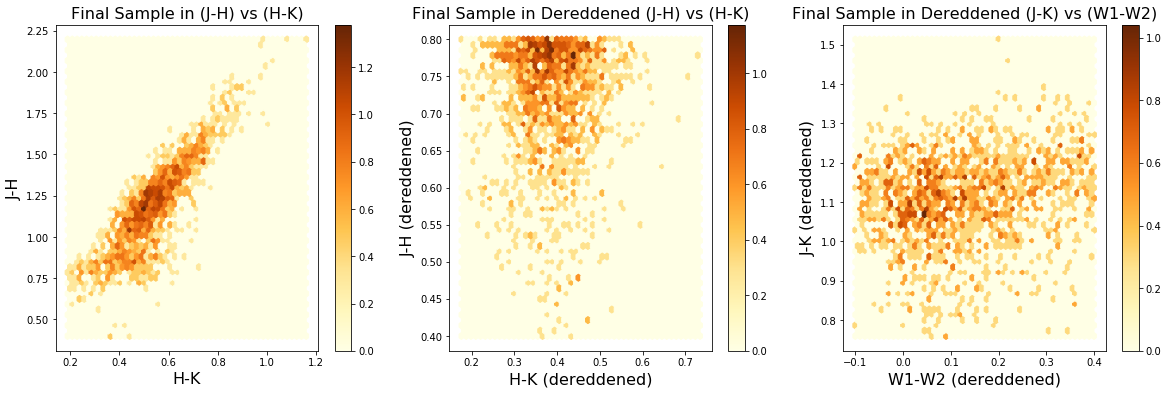

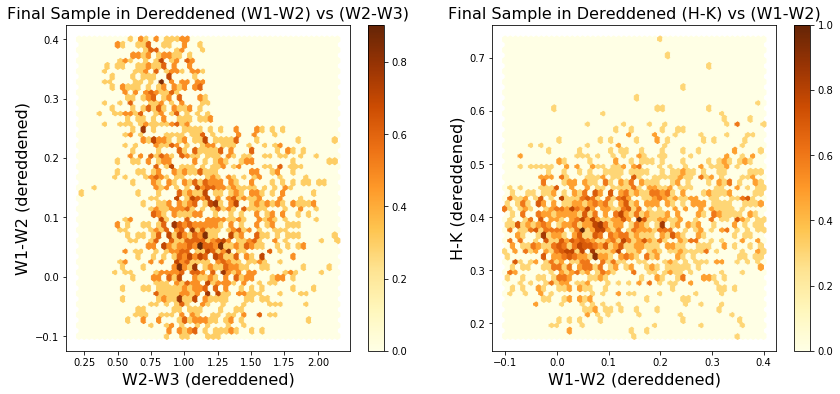

0.384413640617
0.734629431676
3


In [75]:
file1 = open('likely_mdwarfs_20171209_cuts.csv','w')

for obj in mdwarfs_winnow_excess:
    file1.write(obj.zooniverse_id+','+obj.wiseid+'\n')
    
file1.close()

print 'file1 written to file'

file2 = open('apo_visible_targets_20171209_cuts_additional.csv','w')

for obj1 in apo_visible_targets:
    file2.write(obj1.zooniverse_id + ',' + obj1.wiseid+'\n')
    
file2.close()

print 'file2 written to file'


mdwarfs_winnow_excess_jminh, mdwarfs_winnow_excess_hmink, mdwarfs_winnow_excess_jmink, mdwarfs_winnow_excess_w1minw2, mdwarfs_winnow_excess_w2minw3, mdwarfs_winnow_excess_jminh_dereddened, mdwarfs_winnow_excess_hmink_dereddened, mdwarfs_winnow_excess_jmink_dereddened, mdwarfs_winnow_excess_w1minw2_dereddened = get_vecs(mdwarfs_winnow_excess)

mdwarfs_winnow_excess_w2minw3_dereddened = np.array([o.w2minw3_dereddened_use for o in mdwarfs_winnow_excess])

f10, (ax21, ax22, ax23) = plt.subplots(1, 3, figsize=(20, 6))
im21 = ax21.hexbin(mdwarfs_winnow_excess_hmink, mdwarfs_winnow_excess_jminh, gridsize=50, bins='log', cmap='YlOrBr',vmin=0.)
f10.colorbar(im21, ax=ax21)

ax21.set_xlabel('H-K', fontsize=16)
ax21.set_ylabel('J-H', fontsize=16)
#ax21.legend(loc='lower right')
ax21.set_title('Final Sample in (J-H) vs (H-K)', fontsize=16)

im22 = ax22.hexbin(mdwarfs_winnow_excess_hmink_dereddened, mdwarfs_winnow_excess_jminh_dereddened, gridsize=50, bins='log', cmap='YlOrBr',vmin=0.)
f10.colorbar(im22, ax=ax22)

ax22.set_xlabel('H-K (dereddened)', fontsize=16)
ax22.set_ylabel('J-H (dereddened)', fontsize=16)
#ax22.legend(loc='lower right')
ax22.set_title('Final Sample in Dereddened (J-H) vs (H-K)', fontsize=16)

im23 = ax23.hexbin(mdwarfs_winnow_excess_w1minw2_dereddened, mdwarfs_winnow_excess_jmink_dereddened, gridsize=50, bins='log', cmap='YlOrBr', vmin=0.)
f10.colorbar(im23, ax=ax23)

ax23.set_xlabel('W1-W2 (dereddened)', fontsize=16)
ax23.set_ylabel('J-K (dereddened)', fontsize=16)
#ax9.legend(loc='upper left')
ax23.set_title('Final Sample in Dereddened (J-K) vs (W1-W2)', fontsize=16)

plt.show()


f11, (ax24, ax25) = plt.subplots(1,2, figsize = (14, 6))
im24 = ax24.hexbin(mdwarfs_winnow_excess_w2minw3_dereddened, mdwarfs_winnow_excess_w1minw2_dereddened, gridsize=50, bins='log', cmap='YlOrBr', vmin=0.)
f11.colorbar(im24, ax=ax24)

ax24.set_xlabel('W2-W3 (dereddened)', fontsize=16)
ax24.set_ylabel('W1-W2 (dereddened)', fontsize=16)
ax24.set_title('Final Sample in Dereddened (W1-W2) vs (W2-W3)', fontsize=16)

im25 = ax25.hexbin(mdwarfs_winnow_excess_w1minw2_dereddened, mdwarfs_winnow_excess_hmink_dereddened, gridsize=50, bins='log', cmap='YlOrBr', vmin=0.)
f11.colorbar(im25, ax=ax25)

ax25.set_xlabel('W1-W2 (dereddened)', fontsize=16)
ax25.set_ylabel('H-K (dereddened)', fontsize=16)
ax25.set_title('Final Sample in Dereddened (H-K) vs (W1-W2)', fontsize=16)

plt.show()

ra_objects = [o.ra for o in mdwarfs_winnow_excess]
dec_objects = [o.dec for o in mdwarfs_winnow_excess]

window_tonight_ra = [30., 30., 240., 240.]
window_tonight_dec = [90., -40., -40., 90.]

plt.scatter(ra_objects, dec_objects)
plt.plot(window_tonight_ra, window_tonight_dec, 'k', label='Visible 2017-12-23 B half')
plt.xlabel("RA",fontsize=16)
plt.ylabel("DEC", fontsize=16)
plt.legend(loc = 'upper right')
plt.savefig('object_RA.png')

plt.figure()
plt.hexbin(mdwarfs_winnow_excess_w2minw3_dereddened, mdwarfs_winnow_excess_w1minw2_dereddened, gridsize=50, bins='log', cmap='YlOrBr', vmin=0.)
plt.colorbar()
plt.xlabel('W2-W3 (dereddened)', fontsize=18)
plt.ylabel('W1-W2 (dereddened)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

plt.savefig('Final_Mdwarf_sample_WISE.png')

plt.figure()
plt.hexbin(mdwarfs_winnow_excess_hmink_dereddened, mdwarfs_winnow_excess_jminh_dereddened, gridsize=50, bins='log', cmap='YlOrBr', vmin=0.)
plt.colorbar()
plt.xlabel('H-K (dereddened)', fontsize=18)
plt.ylabel('J-H (dereddened)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

plt.savefig('Final_Mdwarf_sample_2MASS.png')

print np.median(mdwarfs_winnow_excess_hmink_dereddened)
print max(mdwarfs_winnow_excess_hmink_dereddened)
too_high = [x for x in mdwarfs_winnow_excess_hmink_dereddened if x >= 0.65]
print len(too_high)

This yields one additional final concern: that what we've captured are really just M giants that didn't need de-reddening (given the appearance of the raw (J-H) vs (H-K) plot). Short of just combing through all of these, however, I'm not sure how we'd weed that out, unless there's additional 3D reddening data that would solve this that I don't know about. An alternative is using the matched-in parallax and proper motion data from the TESS Input Catalog to weed things out via the distance modulus, but I don't know how much of our sample that covers. It could *potentially* be useful as a test set to see how well we did, though.

In [76]:
w1errs = [o.w1magerr for o in mdwarfs_winnow_excess]
print np.median(w1errs)

w4errs = [o.w4magerr for o in mdwarfs_winnow_excess]
print np.median(w4errs)

0.044
0.037


Let's also estimate the absolute J magnitudes of these targets. To do this, we'll read in the (H-K) and M_J data per Mamajek, and then interpolate. In the case that we have targets that exceed what interpolation gives us (three cases), we'll extrapolate based on the (H-K) values closest to those three points.

In [77]:
mamajek_hmink_vec = [0.110,0.125,0.132,0.148,0.167,0.176,0.184,0.193,0.208,0.225,0.228,0.234,0.244,0.252,0.269,0.282,0.301,0.311,0.329,0.352,0.364,0.386,0.422,0.450,0.470,0.480,0.505,0.50,0.54,0.57,0.63]
mamajek_M_J_vec = [4.76, 4.98, 5.18, 5.41, 5.65, 5.78, 5.92,6.04, 6.19, 6.51, 6.69, 6.89, 7.01, 7.40, 8.02, 8.39, 8.79, 9.25, 9.93,10.28,10.47,10.76,10.68,11.23,11.45,11.53,11.78,11.84,12.14,12.34,12.93]

#distance_modulus_vec = []

point63MJ = 13.17

slope = 17.03199
print slope

intercept = 13.17 - (slope*0.63)
print intercept

result_MJ_vec = []

for x in mdwarfs_winnow_excess_hmink_dereddened:
    if x > 0.63:
        continue
    else:
        result_MJ_vec.append(np.interp(x,mamajek_hmink_vec,mamajek_M_J_vec))
        
print min(result_MJ_vec), max(result_MJ_vec)

distance_modulus_vec = [14.5-x for x in result_MJ_vec]
distance_vec = [10.**((x+5)/5) for x in distance_modulus_vec]

volume_vec = [np.pi*4./3.*(x**3) for x in distance_vec]
weight_vec = [1./x for x in volume_vec]

weighted_MJ_vec = []
for i in range(len(weight_vec)):
    weighted_MJ_vec.append(weight_vec[i] * result_MJ_vec[i])
    
print 'weighted:',np.sum(np.array(weighted_MJ_vec))
print 'weight:',np.sum(np.array(weight_vec))

M_J_weighted = np.sum(np.array(weighted_MJ_vec))/np.sum(np.array(weight_vec))

print 'weighted_average:',M_J_weighted

weighted_distance_modulus = 14.5 - M_J_weighted
weighted_distance = 10.**((weighted_distance_modulus+5.)/5.)
weighted_volume = 4./3.*np.pi*(weighted_distance**3.)

print weighted_volume
print len(mdwarfs_winnow_excess_hmink_dereddened)/weighted_volume

17.03199
2.4398463
5.781663396 12.8347515989
weighted: 0.0312742869621
weight: 0.00273858164658
weighted_average: 11.4198848156
295228.119306
0.00512485058523
